In [1]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph yfinance

# Load Envs

In [2]:
import os
from google.colab import userdata
# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# LLM

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

# Adding Memory

In [6]:
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Create State for the Bot

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Parent Class
class AgentState(TypedDict):
  query: str
  messages: Annotated[list[MessagesState], add_messages]

# Creating Structured Output

In [9]:
from pydantic import BaseModel, Field

In [10]:
class OutputStructure(BaseModel):
  header: str = Field(description="The header of the response")
  subheader: str = Field(description="The subheader of the response")
  body: str = Field(description="The body of the response")

### Bind the Schema to the model

In [11]:
llm_with_structure = llm.with_structured_output(OutputStructure)

### Inherit the OutputStructure in the State of Langgraph

In [12]:
# Inherit the key 'messages' from AgentState, which is a list of chat messages
class State(AgentState):
  # Final output in a structured format from llm
  final_output_structure: OutputStructure

# Tools

In [13]:
# Prebuilt Tools

from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [14]:
# Custom Tools

from langchain_core.tools import tool

@tool
def random_func(user_input: str) -> str:
  """
  Surprises user with a random fact.

  Args:
    user_input: string.

  Returns:
    A random fact: String.
  """
  random_prompt = "Surprise the user with something random about {user_input}".format(user_input=user_input)
  return llm.predict(random_prompt)

In [15]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> float:
  """
  Gets a stock price from Yahoo Finance.

  Args:
      ticker: ticker str

  Returns:
    price: float
  """
  # """This is a tool for getting the price of a stock when passed a ticker symbol"""
  stock = yf.Ticker(ticker)
  print(stock)
  print(stock.info)
  return stock.info['previousClose']

In [16]:
tools = [search, wikipedia, random_func, get_stock_price]

### Bind the tools

In [17]:
llm_with_tools = llm.bind_tools(tools)

### Tool Node

In [18]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

# Agent

In [19]:
from langchain_core.messages import HumanMessage, SystemMessage

In [20]:
template = """
  You are a helpful assistant.
  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.
""".strip()

In [21]:
def agentic_func(state: State):
  print("------------ Tool Calling Func ----------")
  print("state: ", state)

  query = state['query']
  messages = state['messages'] # pass the entire state

  # SystemMessage
  system_message = SystemMessage(content=template)
  print("system_message : ", system_message)
  # messages.append(system_message)

  # HumanMessage
  human_message = HumanMessage(content=query)
  print("human_message : ", human_message)
  messages.append(human_message)
  print("messages : ", messages)

  # final query
  final_query = [system_message] + messages
  print("final_query: ", final_query)

  result = llm_with_tools.invoke(final_query)

  return {"messages" : [result]}

In [22]:
def agent_response(state: State):
  print("------------ Agent Response Func ----------")

  # print(state)
  # print("---------")

  # print(state['messages'][-1].content)
  # print("---------")

  ip = state['messages'][-1].content

  ip_message = [HumanMessage(content=ip)]

  # print(ip_message)
  # print("---------")

  response = llm_with_structure.invoke(ip_message)

  # print("final_output_structure: ", response)

  return {"final_output_structure" : response}

# Route

In [23]:
from typing import Literal

def router(state: State) -> Literal["Call Tool", "Final Response"]:
  print("---------- Router ----------")

  tool_identified = state["messages"][-1]


  if tool_identified.tool_calls:
    return "Call Tool"

  return "Final Response"

# Build Graph

In [24]:
from langgraph.graph import START, END, StateGraph

In [25]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Agent", agentic_func)
workflow.add_node("Tools", tool_node)
workflow.add_node("Agent Response", agent_response)


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Agent",   # Tool Calling
    router, # The routing function
    {
        "Call Tool" : "Tools",
        "Final Response" : "Agent Response"
    }
)

## Create Cyclic Edge
workflow.add_edge("Tools", "Agent")

## Create Entry Point
workflow.add_edge(START, "Agent")

## Create End Point
workflow.add_edge("Agent Response", END)

# 4. Compile the Graph
my_graph = workflow.compile(checkpointer=memory) # add memory here

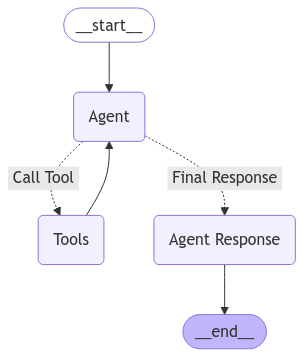

In [26]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# Run Graph

In [27]:
config = {"configurable": {"thread_id": "1"}}

In [28]:
query = "What is the current temperature in Michigan?"
user_input = {"query": query,
              "messages" : []}

In [29]:
result = my_graph.invoke(
    user_input, config, stream_mode="values"
)

------------ Tool Calling Func ----------
state:  {'query': 'What is the current temperature in Michigan?', 'messages': []}
system_message :  content='You are a helpful assistant. \n  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.' additional_kwargs={} response_metadata={}
human_message :  content='What is the current temperature in Michigan?' additional_kwargs={} response_metadata={}
messages :  [HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={}, response_metadata={})]
final_query:  [SystemMessage(content='You are a helpful assistant. \n  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={

In [30]:
result

{'query': 'What is the current temperature in Michigan?',
 'messages': [HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={}, response_metadata={}, id='e44ece02-6c06-4a70-90fb-75424abde853'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_guHbsXraSrsjXlSlNtpCBW9s', 'function': {'arguments': '{"query":"current temperature in Michigan"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 276, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bc179cc7-de36-4543-ac87-9b6059437d7e-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query'

In [31]:
result['final_output_structure']

OutputStructure(header='Weather Update', subheader='Current Temperature in Michigan', body='The current temperature in Michigan is 25°F (-4°C).')

In [32]:
result['final_output_structure'].header

'Weather Update'

In [33]:
result['final_output_structure'].subheader

'Current Temperature in Michigan'

In [34]:
result['final_output_structure'].body

'The current temperature in Michigan is 25°F (-4°C).'

In [35]:
query = "What is the current stock of NVIDIA?"
user_input = {"query": query,
              "messages" : []}

result = my_graph.invoke(
    user_input, config, stream_mode="values"
)

------------ Tool Calling Func ----------
state:  {'query': 'What is the current stock of NVIDIA?', 'messages': [HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={}, response_metadata={}, id='e44ece02-6c06-4a70-90fb-75424abde853'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_guHbsXraSrsjXlSlNtpCBW9s', 'function': {'arguments': '{"query":"current temperature in Michigan"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 276, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bc179cc7-de36-4543-ac87-9b6059437d7e-0', tool_calls=[{'name'

In [36]:
result['final_output_structure']

OutputStructure(header='Stock Price Update', subheader='NVIDIA (NVDA)', body='The current stock price of NVIDIA (NVDA) is $144.47.')